In [1]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers, losses
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
IMG_SIZE = 160
IMAGE_SHAPE = [160,160]

In [3]:
def load_images_from_folder(folderName):
    image_list =[]
    for fileIndex in range(7000):
      img = cv2.imread("./landscape Images/"+folderName+"/"+str(fileIndex)+".jpg")
      if folderName == "color":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
      else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
      image_list.append(img)
    return image_list
color = np.empty((0,IMG_SIZE,IMG_SIZE,3))
gray = np.empty((0,IMG_SIZE,IMG_SIZE,1))
color  = np.append(color,load_images_from_folder(r"color"),0)
gray  = np.append(gray,load_images_from_folder(r"gray"),0)

In [4]:
gray.shape

(7000, 160, 160, 1)

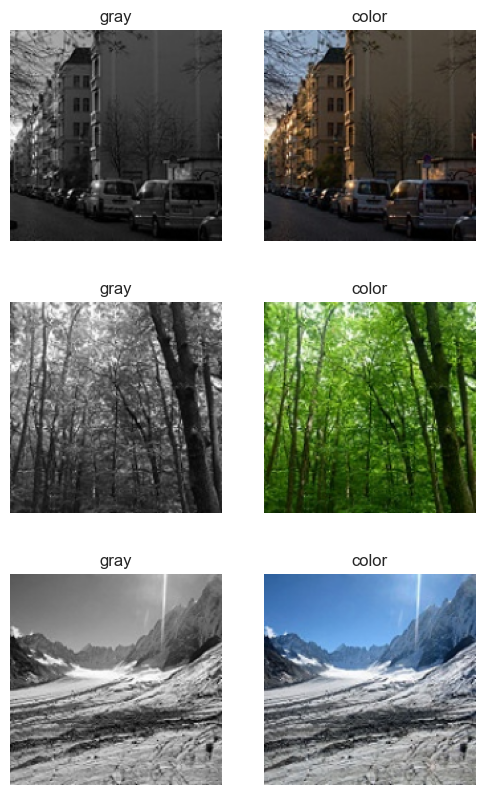

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 10))
for i in range(0,6,2):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(cv2.cvtColor(gray[i].astype('uint8'), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis("off")
  ax = plt.subplot(3, 2, i + 2)
  plt.imshow(color[i].astype('uint8'))
  plt.title("color")
  plt.axis("off")

In [6]:
color /= 255
gray /= 255

In [7]:
def Colorizer(input_shape):
  encoder_input = keras.Input(shape=input_shape)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(encoder_input)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(256, (5, 5), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)

  encoder_output =  layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(x)

  x = layers.UpSampling2D((2, 2))(encoder_output)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(encoder_output)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)(x)
  decoder_output = layers.UpSampling2D((2, 2))(x)
  return keras.Model(encoder_input, decoder_output, name="decoder")

colorizer = Colorizer((160,160,1))

In [8]:
colorizer.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 256)       1638

In [9]:
def loss(y_true,y_pred) :
    l = tf.sqrt(tf.reduce_mean(tf.square(tf.abs(y_true - y_pred))))
    return l

In [10]:
colorizer.compile(loss=loss, optimizer='adam', metrics=['accuracy','mae','mse'])

In [ ]:
colorizer.fit(gray[:6000], color[:6000],batch_size=32,epochs=6,validation_data = (gray[6000:7000], color[6000:7000]))

Epoch 1/6
188/188 [==============================] - 1390s 7s/step - loss: 0.1541 - accuracy: 0.3908 - mae: 0.1173 - mse: 0.0260 - val_loss: 0.1228 - val_accuracy: 0.4489 - val_mae: 0.0895 - val_mse: 0.0151
Epoch 2/6
188/188 [==============================] - 1203s 6s/step - loss: 0.1175 - accuracy: 0.4597 - mae: 0.0841 - mse: 0.0139 - val_loss: 0.1166 - val_accuracy: 0.4824 - val_mae: 0.0848 - val_mse: 0.0137
Epoch 3/6
 10/188 [>.............................] - ETA: 19:20 - loss: 0.1163 - accuracy: 0.4720 - mae: 0.0842 - mse: 0.0136